In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 30

print(ROOT_PATH)

/aiffel/aiffel


# 데이터 가져오기

### 데이터 갯수 확인

In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


validation개수가 너무 소량이다.

### train 데이터와 validation 개수 조정

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 다시 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### train 데이터 속 정상 이미지와 폐렴 이미지 개수 확인

In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


폐렴 이미지 수가 3배정도 많다(CNN 모델의 경우 데이터가 클래스별 balance가 좋을수록 training을 잘 하므로, 데이터가 클래스 불균형(imbalance)한 것은 차후에 조정).   
test와 val 데이터셋은 평가하기 위해서 사용되기 때문에 학습과 관련이 없으므로 imbalance한 데이터 셋이어도 문제없다.

### tf.data 인스턴스 생성

tf.data는 tensorflow에서 학습시킬 때, mini-batch로 작업할 수 있도록 해 준다.

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

### train, validation 데이터셋 개수 확인

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


### label 데이터 생성 함수

In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

### 이미지 가공 함수

이미지 데이터는 현실적으로 사이즈가 제각각일 가능성이 높다.  
이미지의 사이즈를 통일 시키고 GPU 메모리를 더욱 효율적으로 사용하기 위해 이미지 사이즈를 줄이는 과정을 수행

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

리사이즈가 잘 되었는지, 라벨이 잘 들어갔는지 확인

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


### test 데이터셋 생성

위와 같은 방식으로 생성한다.

In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


tf.data 파이프라인을 이용하여 prepare_for_training() 함수를 정의해서 데이터를 변환

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 데이터 시각화

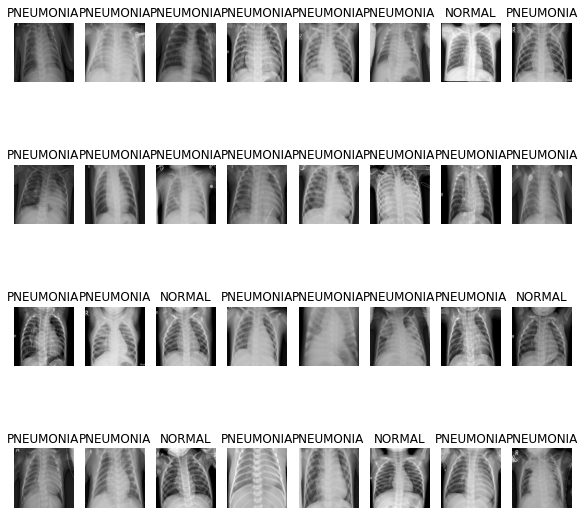

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# CNN 모델링

### convolution block 생성 함수 정의

Convolution을 두 번 진행하고 Batch Normalization을 통해 Gradient vanishing, Gradient Exploding을 해결, 그리고 Max Pooling한다.

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

### Dense block 생성 함수 정의

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Batch Normalization과 Dropout이라는 두 가지 regularization 기법이 동시에 사용되고 있다.
일반적으로 이런 방법은 잘 사용되지 않거나, 금기시되기도 한다(variance shift를 억제하는 Batch Normalization과 이를 유발하는 Dropout을 동시에 사용하는 것이 어울리지 않는다는 논지에서).   
그러나, 실용적으로는 두 방법을 같이 쓰는 것이 낫다고 보는 견해도 없는 것은 아니다. 예외적으로 동시에 사용하는 것이 성능 향상에 도움을 주는 경우도 실제로 있다.

dropout 함수는 과적합을 방지하기 위해 무작위로 특정 노드(입력값)를 0으로 만든다(소괄호 안의 값 = 몇 %의 노드를 0으로 만들지).  
학습시에만 적용되어 모델 정규화를 위해 사용되어야 하며 테스트시에는 적용되서는 안된다.

### 모델 생성 함수 정의

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 데이터 imbalance 처리

Weight balancing 사용 - training set의 각 데이터에서 loss를 계산할 때 특정 클래스의 데이터에 더 큰 loss 값을 갖도록 가중치를 부여하는 방법

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


weight_for_0은 'Normal' 이미지에 사용할 weight를, weight_for_1은 'Pneumonia' 이미지에 사용할 weight를 세팅한다(이 weight들은 'Normal'과 'Pneumonia' 전체 데이터 건수에 반비례하도록 설정됨).

# 모델 훈련

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    # 이미지의 라벨이 2개밖에 없으므로, binary_crossentropy loss 사용
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/30
130/130 [==============================] - 62s 377ms/step - loss: 0.4511 - accuracy: 0.7630 - precision: 0.9500 - recall: 0.7190 - val_loss: 0.5792 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 2/30
130/130 [==============================] - 49s 381ms/step - loss: 0.2188 - accuracy: 0.9103 - precision: 0.9796 - recall: 0.8983 - val_loss: 0.6943 - val_accuracy: 0.7354 - val_precision: 0.7354 - val_recall: 1.0000
Epoch 3/30
130/130 [==============================] - 50s 385ms/step - loss: 0.1534 - accuracy: 0.9421 - precision: 0.9834 - recall: 0.9379 - val_loss: 0.9252 - val_accuracy: 0.7324 - val_precision: 0.7324 - val_recall: 1.0000
Epoch 4/30
130/130 [==============================] - 51s 395ms/step - loss: 0.1474 - accuracy: 0.9466 - precision: 0.9839 - recall: 0.9439 - val_loss: 1.1833 - val_accuracy: 0.7344 - val_precision: 0.7344 - val_recall: 1.0000
Epoch 5/30
130/130 [==============================] - 54s 419ms/step - loss: 0.1313 - accura

# 결과 확인

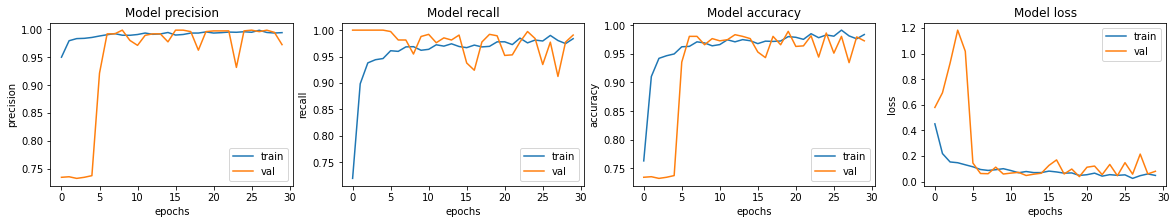

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

iris explolation에서 다뤘던 평가지표 중, positive를 negative로 판단한 값을 분모로 하는 recall(재현율)이 의료 분야에서 중요했다.

### 테스트 데이터로 모델 평가

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

20/20 [==============================] - 5s 239ms/step - loss: 1.3188 - accuracy: 0.7276 - precision: 0.6964 - recall: 1.0000
Loss: 1.318758249282837,
Accuracy: 0.7275640964508057,
Precision: 0.6964285969734192,
Recall: 1.0


# 회고

epochs, batch size, dropout 파라미터를 늘리고 줄이며 조금씩 수정해보았다.

과제를 좀 빨리 시작해 충분히 찾아보고 이것 저것 시도해봤다면 좋았을텐데, 지난 주를 백신 후유증으로 꼬박 앓느라 밀린 노드 진도가 있어 꽤나 촉박하게 진행한 점이 아쉽다. 코드를 작동하는 한 번 한 번이 얼마나 걸리려나 두려워 벌벌 떨며 결과를 기다렸는데, 마지막에 실수로 augmentation을 도입한 코드 부분을 날리고 실행해 72%의 낮은 Accuracy가 나왔다. 도대체 어떤 경위로 그 부분 없이 돌린건지 이해 되지 않지만 원래 세상은 이해 못할 것들 투성이니까 납득한다.  
노드에서도 약 80%는 맞출 수 있게 되었다면서 76%정도가 나오더니 결론적으로 시간에 쫒겨(현재 시각 마감 7분 전) 조금씩 조금씩 나름 85% 가까이 다가가던 Accuracy를 다 깎아먹고 더 낮은 Accuracy를 제출하게 되어 마음 아프다.   
하지만 다음에 잘 하면 되니까~ 제출에 의의를 둔다.